In [17]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from tsai.basics import *
from tsai.all import *

from sklearn.metrics import classification_report, recall_score, precision_score, f1_score

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

    return

In [18]:
# Prepare df

raw_df=pd.read_csv('../data/ts_data2.csv')

raw_df['ReceivedDateTime'] = pd.to_datetime(raw_df['ReceivedDateTime'])

raw_df.sort_values('ReceivedDateTime', inplace=True)

In [19]:
# 3. 길이 조정 함수 정의
def adjust_length(data, target_len):
    current_len = len(data)
    if current_len < target_len:
        # 패딩: 부족한 부분을 0으로 채움
        return np.pad(data, ((0, target_len - current_len), (0, 0)), constant_values=0)
    elif current_len > target_len:
        # 잘라내기: 앞부분만 사용
        return data[:target_len]
    else:
        # 이미 target_len과 같음
        return data

In [20]:
class RecallForZero(Metric):
    def reset(self):
        self.y_true = []
        self.y_pred = []

    def accumulate(self, learn):
        preds = learn.pred.argmax(dim=-1).cpu().numpy()
        targets = learn.y.cpu().numpy()
        self.y_true.extend(targets)
        self.y_pred.extend(preds)

    @property
    def value(self):
        return recall_score(self.y_true, self.y_pred, labels=[0], average=None)[0]
    

class PrecisionForZero(Metric):
    def reset(self):
        self.y_true = []
        self.y_pred = []

    def accumulate(self, learn):
        preds = learn.pred.argmax(dim=-1).cpu().numpy()
        targets = learn.y.cpu().numpy()
        self.y_true.extend(targets)
        self.y_pred.extend(preds)

    @property
    def value(self):
        return precision_score(self.y_true, self.y_pred, labels=[0], average=None)[0]
    

class F1ForZero(Metric):
    def reset(self):
        self.y_true = []
        self.y_pred = []

    def accumulate(self, learn):
        preds = learn.pred.argmax(dim=-1).cpu().numpy()
        targets = learn.y.cpu().numpy()
        self.y_true.extend(targets)
        self.y_pred.extend(preds)

    @property
    def value(self):
        return f1_score(self.y_true, self.y_pred, labels=[0], average=None)[0]

#### Result ####


epoch,train_loss,valid_loss,accuracy,time
0,0.213017,0.176165,0.958462,00:02
1,0.194763,0.200477,0.958462,00:02
2,0.179586,0.193852,0.958462,00:02
3,0.169933,0.216452,0.952692,00:02
4,0.157429,0.235239,0.940769,00:02


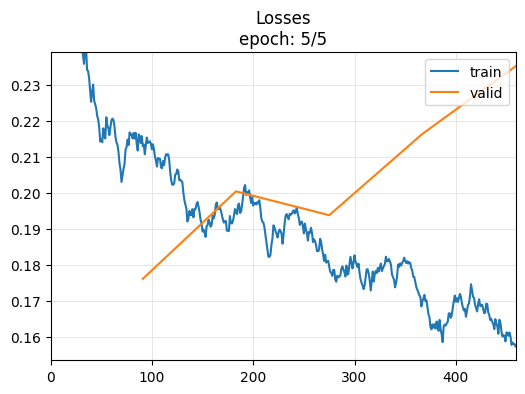

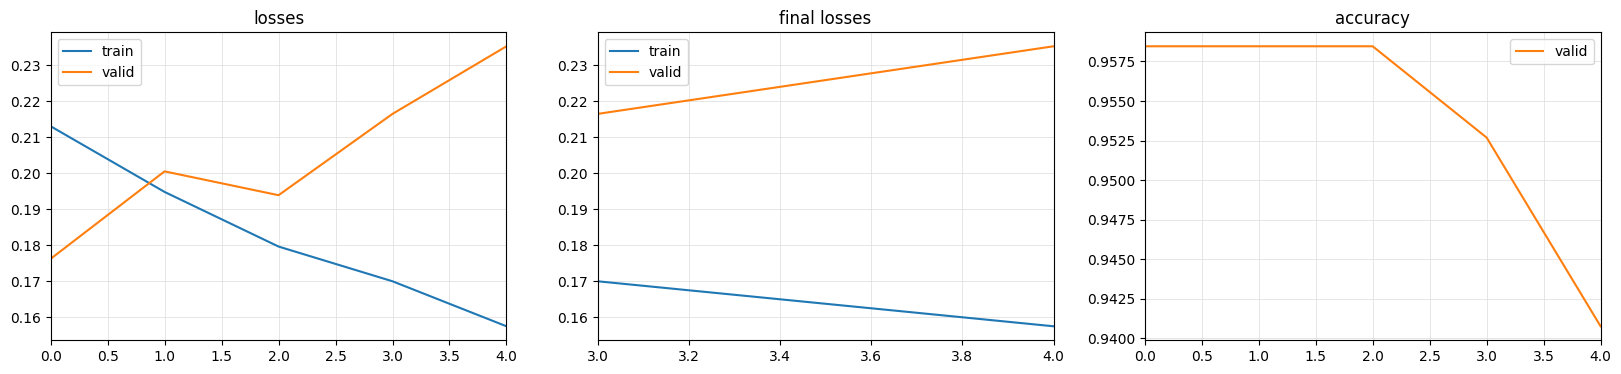

Result
Classification Report:
              precision    recall  f1-score   support

           0     0.0893    0.0463    0.0610       108
           1     0.9595    0.9795    0.9694      2492

    accuracy                         0.9408      2600
   macro avg     0.5244    0.5129    0.5152      2600
weighted avg     0.9234    0.9408    0.9317      2600

#### 내경_Result ####


epoch,train_loss,valid_loss,accuracy,time
0,0.078688,0.038242,0.999615,00:02
1,0.056624,0.041127,0.999615,00:02
2,0.038847,0.137638,0.996154,00:02
3,0.026479,0.208551,0.898462,00:02
4,0.015116,0.566201,0.717308,00:02


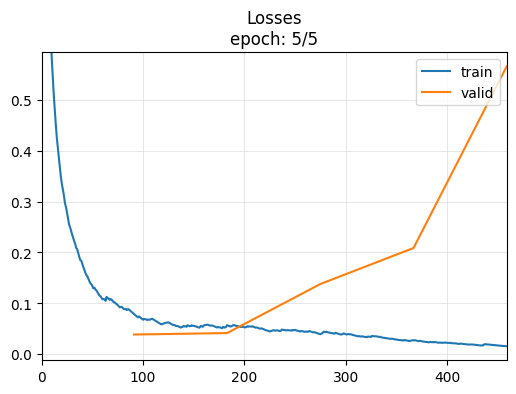

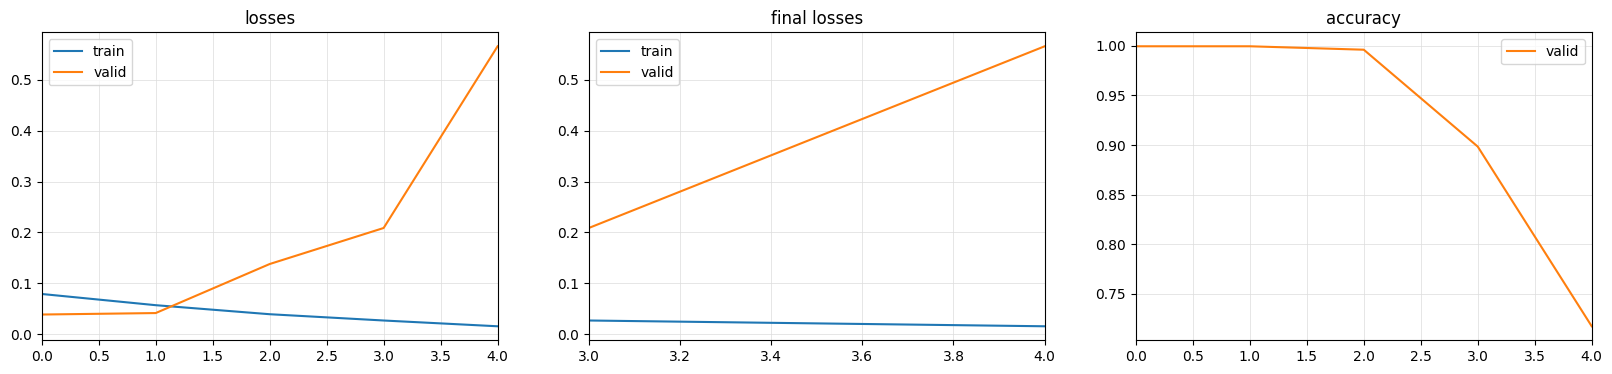

내경_Result
Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         1
           1     0.9995    0.7176    0.8354      2599

    accuracy                         0.7173      2600
   macro avg     0.4997    0.3588    0.4177      2600
weighted avg     0.9991    0.7173    0.8351      2600

#### 그루브깊이_Result ####


epoch,train_loss,valid_loss,accuracy,time
0,0.052054,0.112691,0.983846,00:02
1,0.043229,0.104081,0.983846,00:02
2,0.041366,0.098839,0.983846,00:02
3,0.038461,0.103788,0.983846,00:02
4,0.026613,0.103171,0.983846,00:02


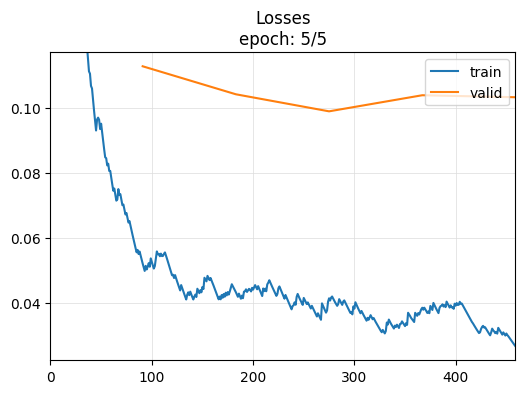

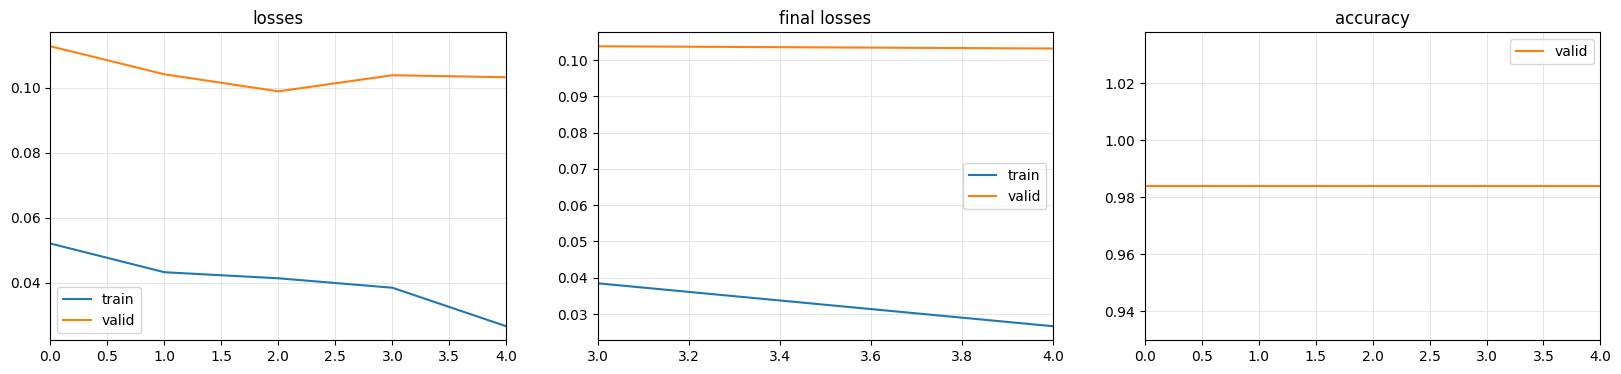

그루브깊이_Result
Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        42
           1     0.9838    1.0000    0.9919      2558

    accuracy                         0.9838      2600
   macro avg     0.4919    0.5000    0.4959      2600
weighted avg     0.9680    0.9838    0.9758      2600

#### 위치도_Result ####


epoch,train_loss,valid_loss,accuracy,time
0,0.198838,0.128957,0.972692,00:02
1,0.185151,0.147214,0.972692,00:02
2,0.177366,0.142814,0.972692,00:02
3,0.176981,0.157863,0.972308,00:02
4,0.159069,0.186327,0.956154,00:02


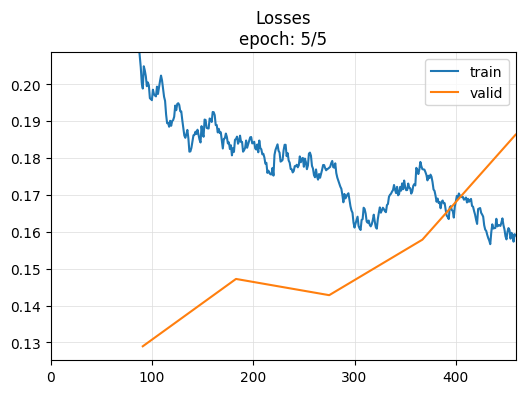

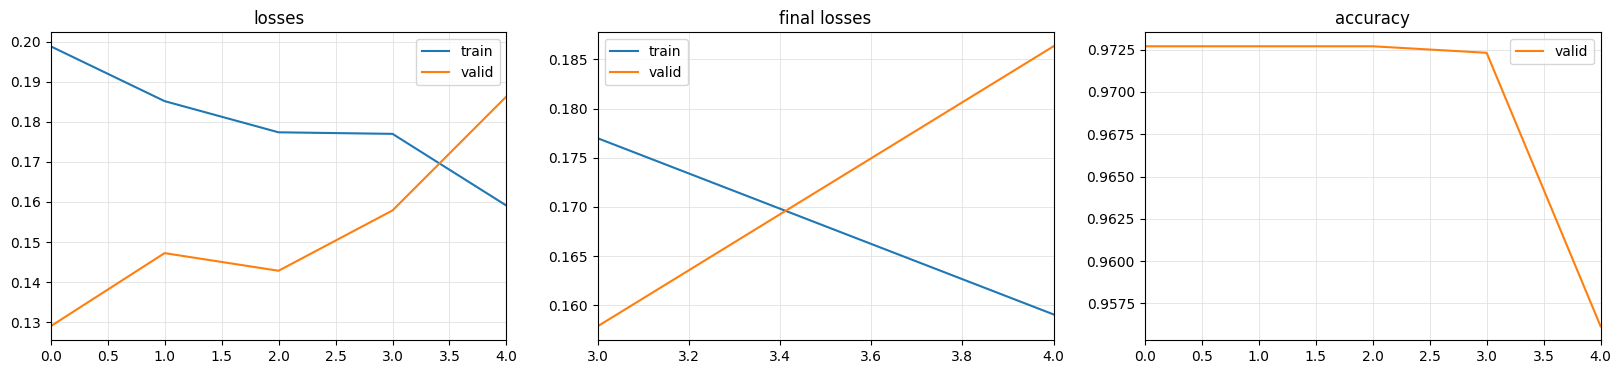

위치도_Result
Classification Report:
              precision    recall  f1-score   support

           0     0.0222    0.0141    0.0172        71
           1     0.9726    0.9826    0.9776      2529

    accuracy                         0.9562      2600
   macro avg     0.4974    0.4983    0.4974      2600
weighted avg     0.9467    0.9562    0.9514      2600

#### 진원도_Result ####


epoch,train_loss,valid_loss,accuracy,time
0,0.056735,0.025668,0.999231,00:02
1,0.034520,0.018031,0.999231,00:02
2,0.028651,0.013089,0.999231,00:02
3,0.026013,0.041497,0.999231,00:02
4,0.020381,0.072654,0.997692,00:02


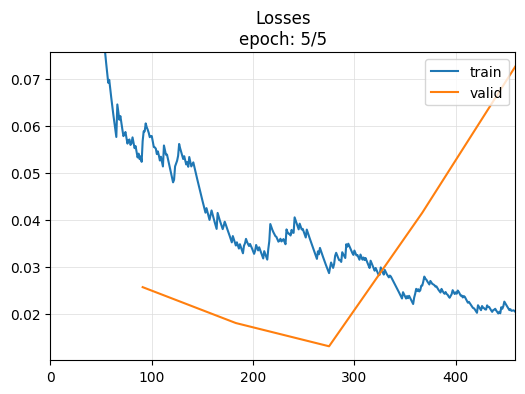

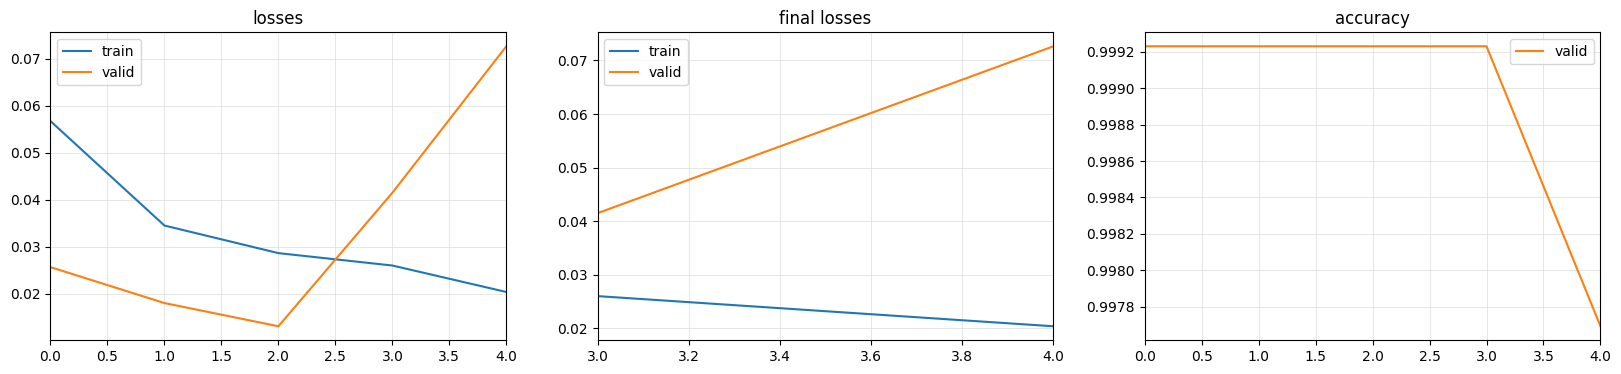

진원도_Result
Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         2
           1     0.9992    0.9985    0.9988      2598

    accuracy                         0.9977      2600
   macro avg     0.4996    0.4992    0.4994      2600
weighted avg     0.9985    0.9977    0.9981      2600

#### 그루브경_Result ####


epoch,train_loss,valid_loss,accuracy,time
0,0.048465,0.006929,0.999231,00:02
1,0.027243,0.026724,0.999231,00:02
2,0.020594,0.020305,0.999231,00:02
3,0.019310,0.027143,0.999231,00:02
4,0.016345,0.035130,0.999231,00:02


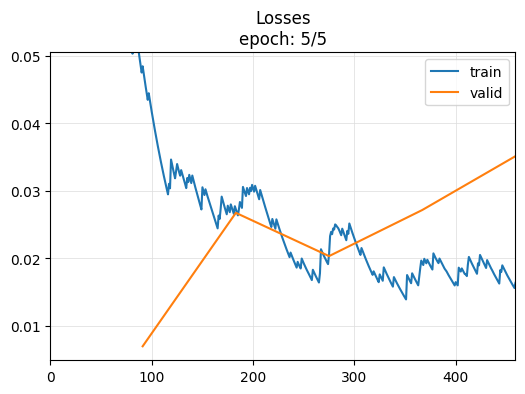

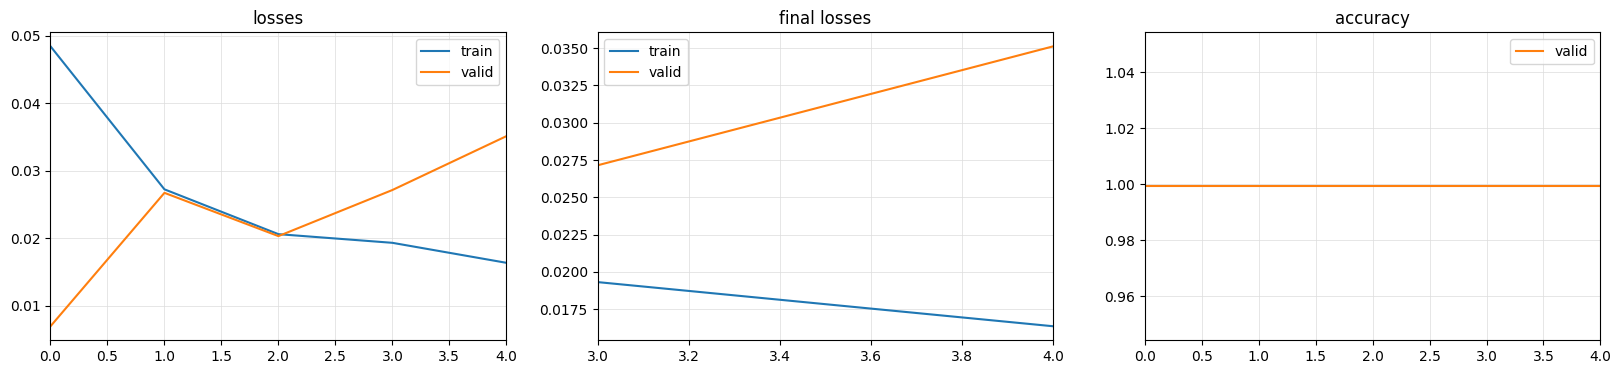

그루브경_Result
Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         2
           1     0.9992    1.0000    0.9996      2598

    accuracy                         0.9992      2600
   macro avg     0.4996    0.5000    0.4998      2600
weighted avg     0.9985    0.9992    0.9988      2600



In [9]:
target_columns = [ 'Result', '내경_Result', '그루브깊이_Result', '위치도_Result', '진원도_Result', '그루브경_Result',]

#target_columns=['진원도_Result']
# 사용할 피처와 그룹화할 컬럼 정의
feature_columns = ['ActF', 'SpindleSpeed', 'ModalT_x', 'servoload_x', 
                   'servoload_z', 'servocurrent_x', 'servocurrent_z', 'SpindleLoad']

grouped = raw_df.groupby('SerialNo')  # SerialNo를 기준으로 그룹화

# 2. SerialNo별 시계열 길이 계산
series_lengths = grouped.size()  # SerialNo별 시계열 길이
median_length = int(series_lengths.median())  # 중앙값 계산

# 4. SerialNo별 데이터 길이 조정
X = np.stack([
    adjust_length(group[feature_columns].values, median_length)
    for _, group in grouped
])

# Train/Test Split
train_idx = raw_df[raw_df['ReceivedDateTime'] < pd.to_datetime('2023-06-01')].groupby('SerialNo').ngroup().unique()  # 학습 데이터
test_idx = raw_df[raw_df['ReceivedDateTime'] >= pd.to_datetime('2023-06-01')].groupby('SerialNo').ngroup().unique()  # 테스트 데이터
splits = (list(train_idx), list(train_idx[-1] + test_idx + 1))
    
for target in target_columns:
    print(f"#### {target} ####")
    # y값 생성 (SerialNo별 Result 값의 대표값 사용)
    y = grouped[target].first().values

    serials = grouped['SerialNo'].first().values  # SerialNo 리스트

    # 2. 모델 학습
    tfms = [None, TSClassification()]  # 데이터 변환
    batch_tfms = TSStandardize(by_sample=True)  # 표준화

    # 다변량 시계열 분류 모델 생성
    mv_clf = TSClassifier(X, y, splits=splits, path='models', 
                          arch="InceptionTimePlus", tfms=tfms, 
                          batch_tfms=batch_tfms, metrics=accuracy, cbs=ShowGraph())
    
    mv_clf.fit_one_cycle(5, 1e-2)  # 10 에포크 동안 학습
    mv_clf.export(f"{target}_inception.pkl")  # 모델 저장

    # 3. 모델 로드 및 예측
    mv_clf = load_learner(f"models/{target}_inception.pkl")  # 모델 로드
    X_test = X[splits[1]]  # 테스트 데이터
    y_test = y[splits[1]]  # 테스트 타겟값

    probas, actual, preds = mv_clf.get_X_preds(X_test, y_test)  # 확률, 실제값, 예측값

    # 4. 결과 출력
    test_serials = serials[splits[1]]  # 테스트 데이터에 해당하는 SerialNo
    results = pd.DataFrame({
        'SerialNo': test_serials,
        'Actual': actual,
        'Predicted': preds
    })
    
    from sklearn.metrics import classification_report

    # Actual과 Predicted 값을 가져오기
    actual = results['Actual']  # 이미 int 타입
    predicted = results['Predicted'].astype(int)  # 문자열을 정수형으로 변환

    # Classification Report 출력
    print(target)
    report = classification_report(actual, predicted, digits=4)
    print("Classification Report:")
    print(report)


X.shape: (2599, 260, 8)
y.shape: (2599,)
Selected metric: accuracy
Computing step importance...


  0 step: BASELINE             accuracy: 1.000000


  1 step: 0                    accuracy: 1.000000


  2 step: 1                    accuracy: 1.000000


  3 step: 2                    accuracy: 1.000000


  4 step: 3                    accuracy: 1.000000


  5 step: 4                    accuracy: 1.000000


  6 step: 5                    accuracy: 1.000000


  7 step: 6                    accuracy: 1.000000


  8 step: 7                    accuracy: 1.000000



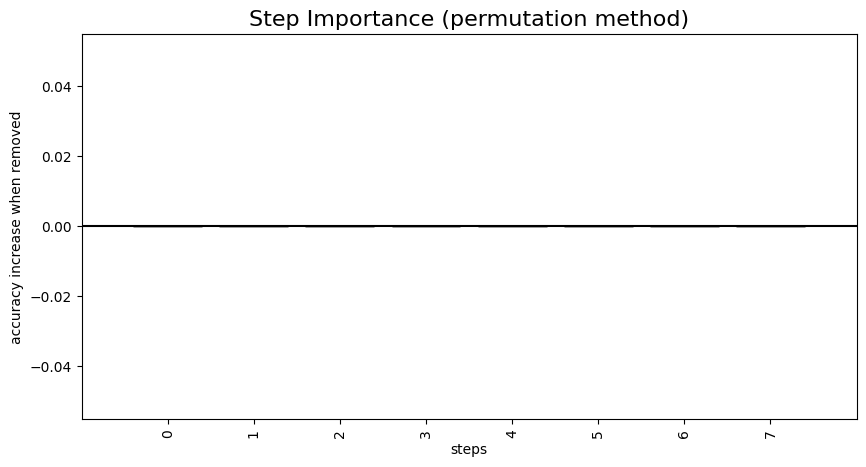

,Step,accuracy,accuracy_change
0,BASELINE,1.0,0.0
1,0,1.0,0.0
2,1,1.0,0.0
3,2,1.0,0.0
4,3,1.0,0.0
5,4,1.0,0.0
6,5,1.0,0.0
7,6,1.0,0.0
8,7,1.0,0.0


In [62]:
mv_clf.step_importance(X=X_test, y=y_test, show_chart=True, return_df=True)

In [63]:
feature_importances = mv_clf.feature_importance(X=X_test, y=y_test, show_chart=True, return_df=True)

X.shape: (2599, 260, 8)
y.shape: (2599,)
Selected metric: accuracy
Computing feature importance (permutation method)...


  0 feature: BASELINE             accuracy: 1.000000


: 

In [10]:
demo_df = pd.read_csv('../data/demo.csv')
demo_df

,ReceivedDateTime,RestartCount,SerialNo,ActF,SpindleSpeed,ModalT_x,ReadDateTime,TotalCount,servoload_x,servoload_z,...,위치도2번_Result,위치도3번_Result,위치도4번_Result,위치도5번_Result,내경_Result,그루브경1번_Result,그루브경2번_Result,그루브경3번_Result,그루브경4번_Result,그루브경5번_Result
0,2023-01-01 23:22:44.000,1,20230102-0001-00003,0,0.0,700,2023-01-01 23:22:44.056,32.0,21.0,1.0,...,1,1,1,1,1,1,1,1,1,1
1,2023-01-01 23:22:44.500,1,20230102-0001-00003,6694,0.0,400,2023-01-01 23:22:44.558,32.0,2.0,22.0,...,1,1,1,1,1,1,1,1,1,1
2,2023-01-01 23:22:45.000,1,20230102-0001-00003,6694,0.0,400,2023-01-01 23:22:45.058,32.0,2.0,22.0,...,1,1,1,1,1,1,1,1,1,1
3,2023-01-01 23:22:45.500,1,20230102-0001-00003,0,666.0,404,2023-01-01 23:22:45.560,32.0,2.0,22.0,...,1,1,1,1,1,1,1,1,1,1
4,2023-01-01 23:22:46.000,1,20230102-0001-00003,0,666.0,404,2023-01-01 23:22:46.061,32.0,7.0,5.0,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,2023-01-01 23:25:05.500,1,20230102-0001-00003,0,0.0,700,2023-01-01 23:25:05.558,33.0,22.0,0.0,...,1,1,1,1,1,1,1,1,1,1
284,2023-01-01 23:25:06.000,1,20230102-0001-00003,0,0.0,700,2023-01-01 23:25:06.060,33.0,22.0,0.0,...,1,1,1,1,1,1,1,1,1,1
285,2023-01-01 23:25:06.500,1,20230102-0001-00003,0,0.0,700,2023-01-01 23:25:06.570,33.0,22.0,0.0,...,1,1,1,1,1,1,1,1,1,1
286,2023-01-01 23:25:07.000,1,20230102-0001-00003,0,0.0,700,2023-01-01 23:25:07.062,33.0,21.0,1.0,...,1,1,1,1,1,1,1,1,1,1


In [11]:
def add_result(df):
    result_mapping = {
        '그루브깊이': ['그루브깊이1번_Result', '그루브깊이2번_Result', '그루브깊이3번_Result', '그루브깊이4번_Result', '그루브깊이5번_Result'],
        '위치도': ['위치도1번_Result', '위치도2번_Result', '위치도3번_Result', '위치도4번_Result', '위치도5번_Result'],
        '진원도': ['진원도1번_Result', '진원도2번_Result', '진원도3번_Result', '진원도4번_Result', '진원도5번_Result'],
        '그루브경': ['그루브경1번_Result', '그루브경2번_Result', '그루브경3번_Result', '그루브경4번_Result', '그루브경5번_Result']
    }

    # ***_Result 열 4개 추가
    for new_col, related_cols in result_mapping.items():
        df[f'{new_col}_Result'] = df[related_cols].apply(lambda x: 0 if (x == 0).any() else 1, axis=1)
    
    return df

demo_df = add_result(demo_df)

In [12]:
demo_df = add_result(demo_df)

In [13]:

target_columns = ['Result', '내경_Result', '그루브깊이_Result', '위치도_Result', '진원도_Result', '그루브경_Result']
# 사용할 피처와 그룹화할 컬럼 정의
feature_columns = ['ActF', 'SpindleSpeed', 'ModalT_x', 'servoload_x', 
                   'servoload_z', 'servocurrent_x', 'servocurrent_z', 'SpindleLoad']
grouped = demo_df.groupby('SerialNo')  # SerialNo를 기준으로 그룹화
# 2. SerialNo별 시계열 길이 계산
series_lengths = grouped.size()  # SerialNo별 시계열 길이
median_length = 260  # 중앙값 계산

# 4. SerialNo별 데이터 길이 조정
X = np.stack([
    adjust_length(group[feature_columns].values, median_length)
    for _, group in grouped
])
for target in target_columns:
    test_idx = demo_df[demo_df['ReceivedDateTime'] >= '2023-01'].groupby('SerialNo').ngroup().unique()  # 테스트 데이터 -> 전체 사용
    # 어차피 train data 안 씀
    splits = (0, list(test_idx))
    # y값 생성 (SerialNo별 Result 값의 대표값 사용)
    y = grouped[target].first().values
    serials = grouped['SerialNo'].first().values  # SerialNo 리스트
    # 3. 모델 로드 및 예측
    mv_clf = load_learner(f"models/{target}_inception.pkl")  # 모델 로드
    X_test = X[splits[1]]  # 테스트 데이터
    y_test = y[splits[1]]  # 테스트 타겟값
    probas, target, preds = mv_clf.get_X_preds(X_test, y_test)  # 확률, 실제값, 예측값
    # 4. 결과 출력
    test_serials = serials[splits[1]]  # 테스트 데이터에 해당하는 SerialNo
    results = pd.DataFrame({
        'SerialNo': test_serials,
        'Actual': target,
        'Predicted': preds
    })
    print(probas)
    # Actual과 Predicted 값을 가져오기
    actual = results['Actual']  # 이미 int 타입
    predicted = results['Predicted'].astype(int)  # 문자열을 정수형으로 변환
    # Classification Report 출력
    report = classification_report(actual, predicted, digits=4)
    print("Classification Report:")
    print(report)
    

tensor([[0.0112, 0.9888]])
Classification Report:
              precision    recall  f1-score   support

           1     1.0000    1.0000    1.0000         1

    accuracy                         1.0000         1
   macro avg     1.0000    1.0000    1.0000         1
weighted avg     1.0000    1.0000    1.0000         1



tensor([[3.6478e-04, 9.9964e-01]])
Classification Report:
              precision    recall  f1-score   support

           1     1.0000    1.0000    1.0000         1

    accuracy                         1.0000         1
   macro avg     1.0000    1.0000    1.0000         1
weighted avg     1.0000    1.0000    1.0000         1



tensor([[5.9093e-05, 9.9994e-01]])
Classification Report:
              precision    recall  f1-score   support

           1     1.0000    1.0000    1.0000         1

    accuracy                         1.0000         1
   macro avg     1.0000    1.0000    1.0000         1
weighted avg     1.0000    1.0000    1.0000         1



tensor([[0.0258, 0.9742]])
Classification Report:
              precision    recall  f1-score   support

           1     1.0000    1.0000    1.0000         1

    accuracy                         1.0000         1
   macro avg     1.0000    1.0000    1.0000         1
weighted avg     1.0000    1.0000    1.0000         1



tensor([[4.8277e-04, 9.9952e-01]])
Classification Report:
              precision    recall  f1-score   support

           1     1.0000    1.0000    1.0000         1

    accuracy                         1.0000         1
   macro avg     1.0000    1.0000    1.0000         1
weighted avg     1.0000    1.0000    1.0000         1



tensor([[0.0045, 0.9955]])
Classification Report:
              precision    recall  f1-score   support

           1     1.0000    1.0000    1.0000         1

    accuracy                         1.0000         1
   macro avg     1.0000    1.0000    1.0000         1
weighted avg     1.0000    1.0000    1.0000         1



In [22]:
# Hack_Inception.ipynb 내부
!jupyter nbconvert --to script Hack_Inception.ipynb


[NbConvertApp] Converting notebook Hack_Inception.ipynb to script
[NbConvertApp] Writing 8390 bytes to Hack_Inception.py


In [ ]:
# INFERENCE
# 3. 모델 로드 및 예측
# 사용할 피처와 그룹화할 컬럼 정의
feature_columns = ['ActF', 'SpindleSpeed', 'ModalT_x', 'servoload_x', 
                   'servoload_z', 'servocurrent_x', 'servocurrent_z', 'SpindleLoad']
grouped = raw_df.groupby('SerialNo')  # SerialNo를 기준으로 그룹화

# 2. SerialNo별 시계열 길이 계산
series_lengths = grouped.size()  # SerialNo별 시계열 길이
median_length = int(series_lengths.median())  # 중앙값 계산
print(f"시계열 길이 중앙값: {median_length}")


# 4. SerialNo별 데이터 길이 조정
X = np.stack([
    adjust_length(group[feature_columns].values, median_length)
    for _, group in grouped
])

mv_clf = load_learner(f"models/내경_Result_inception.pkl")  # 모델 로드
X_test = X[splits[1]]  # 테스트 데이터
y_test = y[splits[1]]  # 테스트 타겟값
probas, target, preds = mv_clf.get_X_preds(X_test, y_test)  # 확률, 실제값, 예측값
# 4. 결과 출력
test_serials = serials[splits[1]]  # 테스트 데이터에 해당하는 SerialNo
results = pd.DataFrame({
    'SerialNo': test_serials,
    'Actual': target,
    'Predicted': preds
})

# Actual과 Predicted 값을 가져오기
actual = results['Actual']  # 이미 int 타입
predicted = results['Predicted'].astype(int)  # 문자열을 정수형으로 변환
# Classification Report 출력
report = classification_report(actual, predicted, digits=4)
print("Classification Report:")
print(report)

In [26]:
print(f"Train 데이터 크기: {len(train_idx)}")
print(f"Test 데이터 크기: {len(test_idx)}")


Train 데이터 크기: 5883
Test 데이터 크기: 2599
